**Lecture 3: Graphs models + shortest path**

Graphs that we think of are just visual presentations of information

What is a graph?
- Start with a set of nodes (vertices)
- Set of edges (arcs) that connect a pair of nodes 
- - Can be weighted or unweighted (for now assume non-negative)
- - Undirected (graph)
- - Directed (digraph)
- - - Source (parent) and destination (child) nodes
- Graph might not be completely connected, could have loops as well

Ex. graph is a roadmap with the edges being rodes, nodes being destinations, and weights being distances

***Path***:
- A set of edges connecting one node to another
- Ex. B -> A -> C -> D

Trees (a special case):
-> Directed graph in which any pair of nodes is connected by a unique path from the node closer to the root to the node further from the root
---> For example the binary search trees we used for the knapsack problem


What are they useful for?
- Capture and reason about `relationships` among entities
- - Routes, atom relationships, family trees, political connections
- Support inference on those structures
- - Find least expensive path --> `shortest-path-problem`
- - Parition graph into equal subgraphs with minimal connections --> `graph partition`
- - Find most efficient way to separate sets of connected elements --> `min-cut max flow problem`



**Classic Problem**
- Shortest (unweighted) path
- - Fewest number of edges from a source node to a destination node
- Shortest weighted path
- - Minimizes the sum of the weights of its edges

Ex. Route from a city to another, warehouse logistics, path for molecule through a chemical labyrinth



***Implementing Graphs***

-> Digraph is a directed graph
- Edges pass in one direction only
- Need to represent collection of edges

-> Adjacency Matrix
- Rows: source nodes
- Columns: destination nodes
- Cell[s, d] = 1 if there is an edge from s to d, 0 otherwise
- Uses O(nodes**2) memory
- Easily generalized to weighted edges and to multiple edges between nodes

-> Adjacency List
- Associate with each node a list of destination nodes that can be reached with one edge
- Uses O(edges) memory and is good for sparse graphs
- Easily extended to weighted edges my making each item in the list a dictionary key weight pair

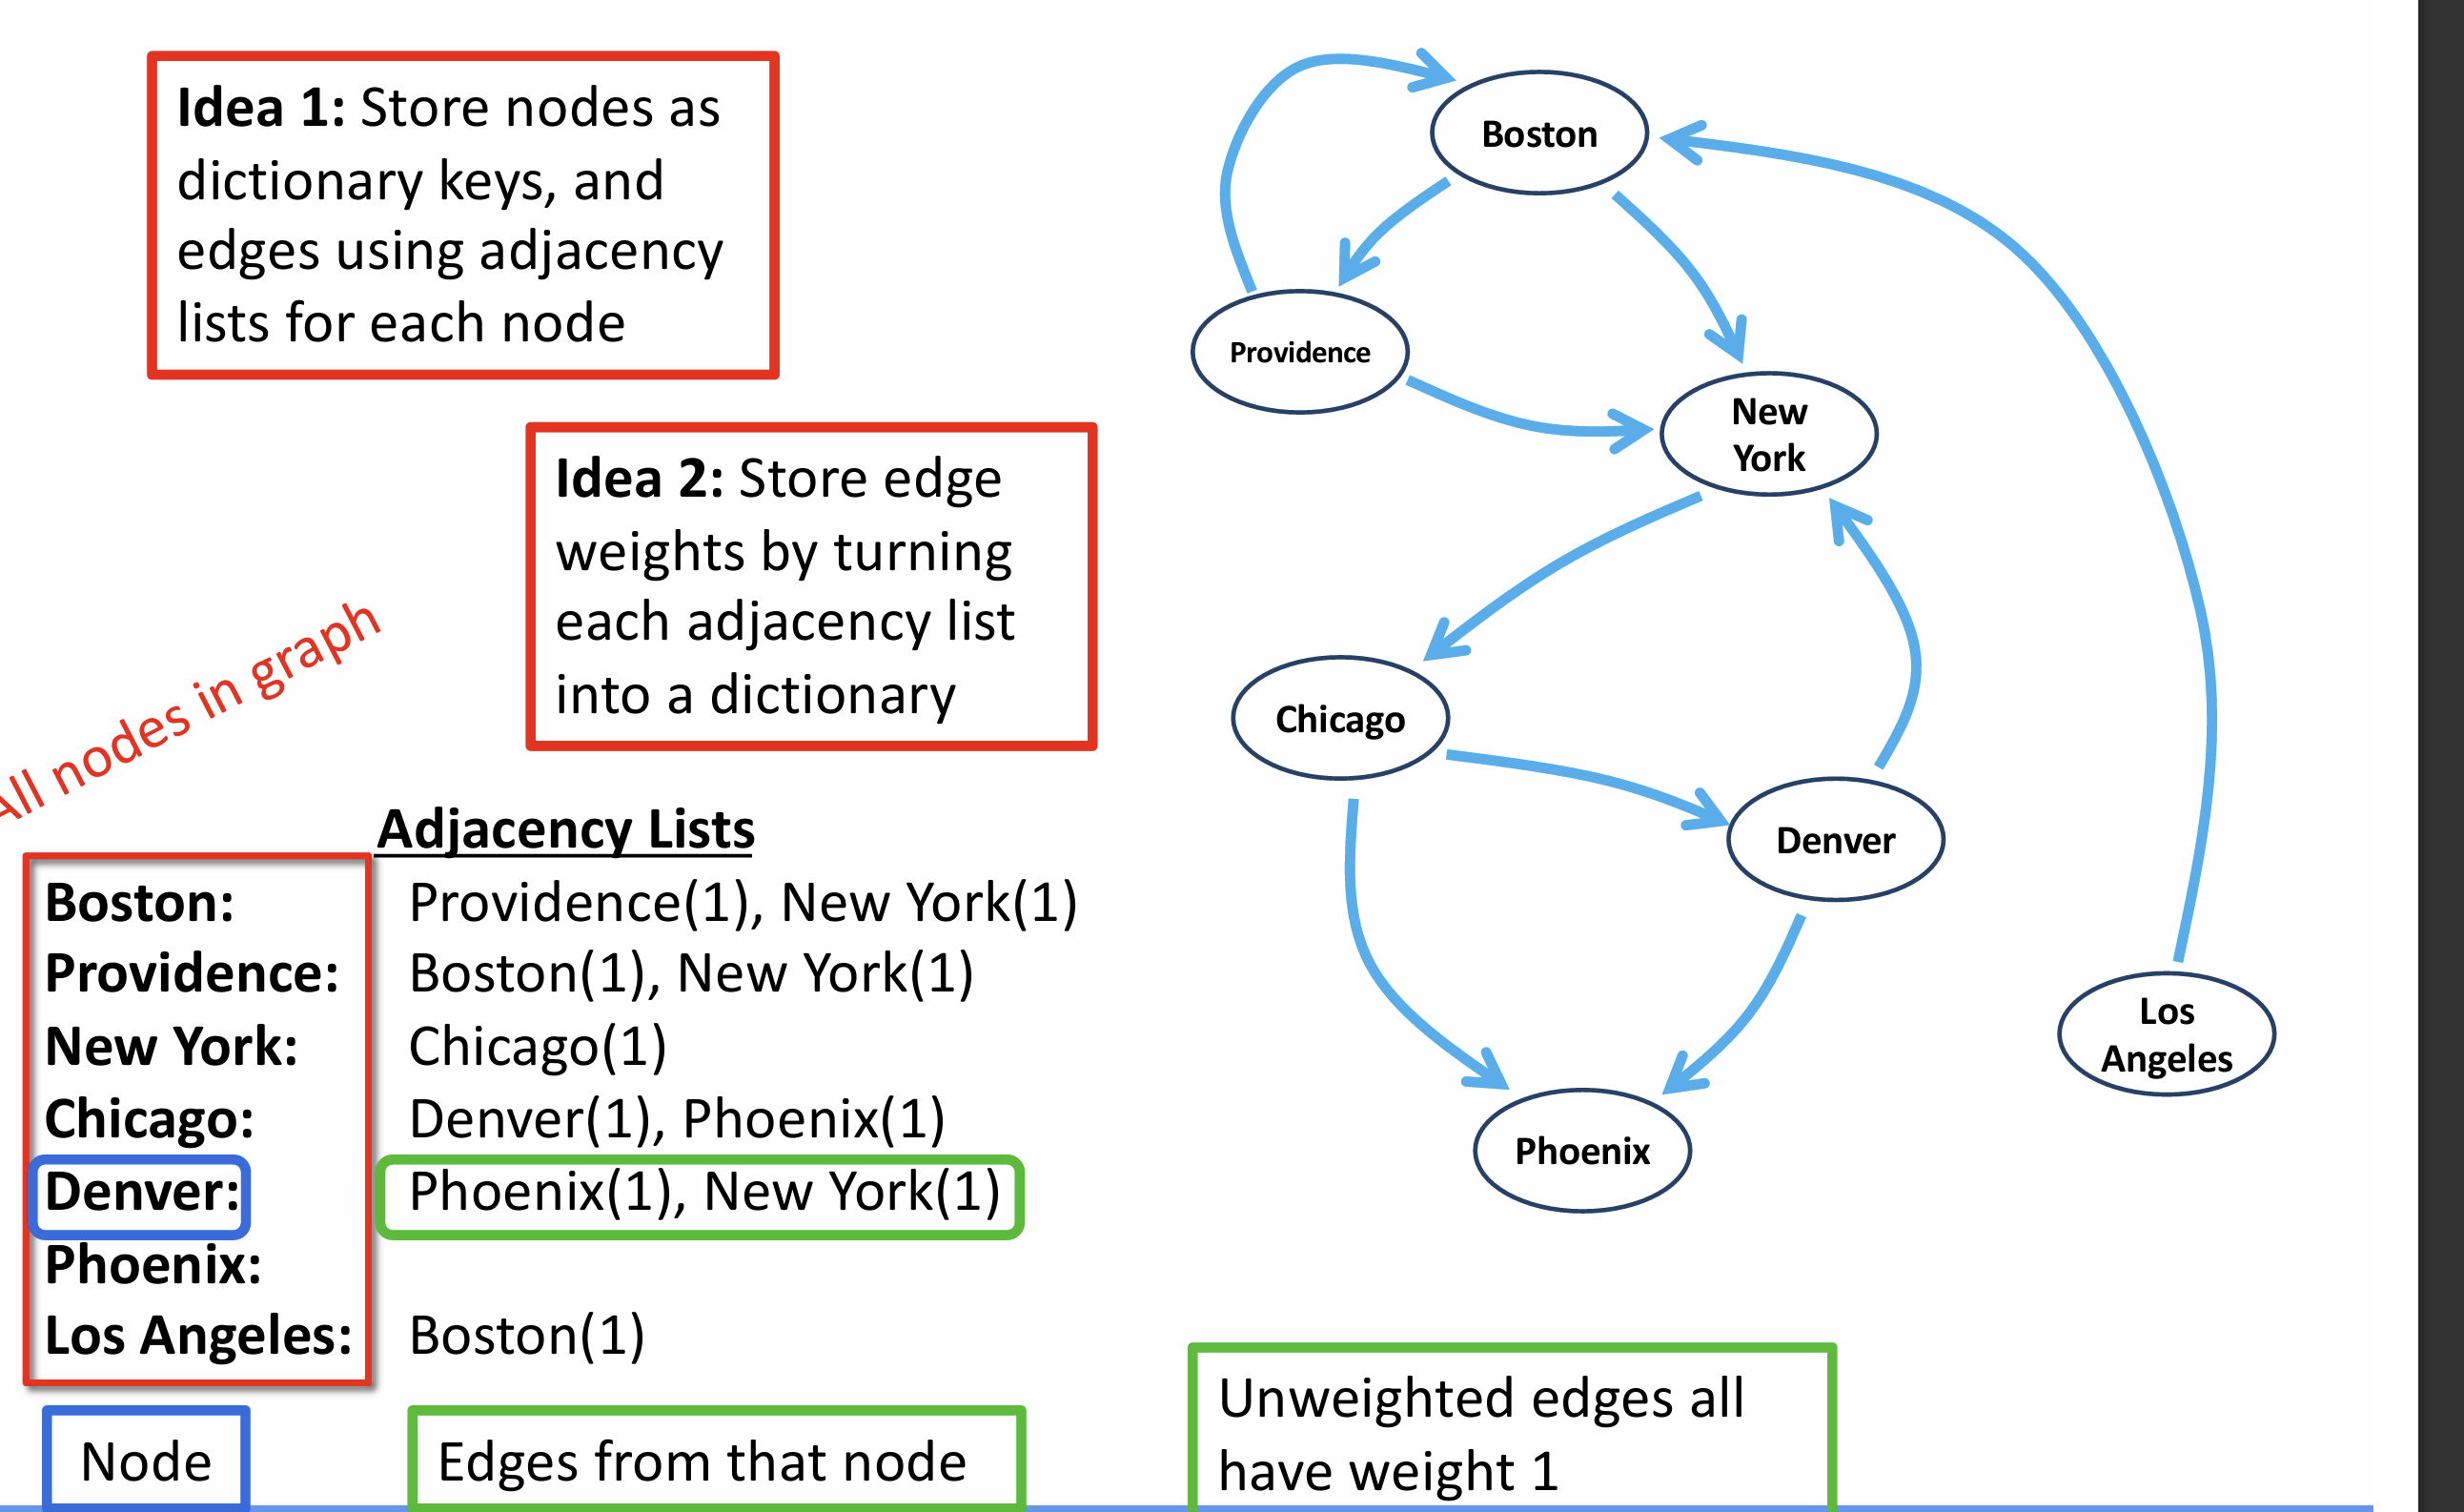

In [ ]:
#example code
class Digraph:
    def __init__(self, nodes=()):
        self._edges = {}
        for node in nodes:
            self.add_node(node)

    def add_node(self, node):
        if node in self._edges:
            raise ValueError('duplicate node')

    def add_edge(self, src, dest, weight=1):
        if src not in self._edges:
            self.add_node(src)
        if dest not in self._edges:
            self.add_node(dest)

        self._edges[src][dest] = weight

    def has_node(self, node):
        return node in self._edges

    def get_all_nodes(self):
        return list(self._edges.keys())

    def outgoing_edges_of(self, node):
        return self._edges[node].copy()

    def children_of(self, node):
        return list(self.outgoing_edges_of(node).keys())

    def __str__(self):
        vals = []
        for src in self._edges:
            entry = src + ': '
            for dest, weight in self._edges[src].items():
                entry += f'{dest}({weight}), '
            if entry[-2:] != ': ': # There was at least one edge
                vals.append(entry[:-2])
            else:
                vals.append(entry[:-1])
        vals.sort(key=lambda x: x.split(':')[0])
        result = ''
        for v in vals:
            result += v + '\n'
        return result[:-1]


#ASSUMPTIONS: Nodes are immutable objects so they can be used as dictionary keys
# No multiple edges

***Observation***:
- Undirected edge can be represented as pair of opposite directed edges
- Undirected graph can resuse funtionality

In [5]:
class Graph(Digraph):

    def add_edge(self, node1, node2, weight=1):
        super().add_edge(node1, node2, weight)
        super().add_edge(node2, node1, weight)

Why make undirected graph a subclass of digraph rather than vice versa

Follow the Substitution Principle --> Subclass behavior should be consistent with superclass
- The undirected graph follows digraph behavior but not the other way around


In [6]:
def build_test_graph(graph_type):
    g = graph_type()
    g.add_edge('A', 'B')
    g.add_edge('A', 'C')
    g.add_edge('A', 'D')
    g.add_edge('B', 'E')
    g.add_edge('C', 'E')
    g.add_edge('C', 'F')
    g.add_edge('C', 'G')
    g.add_edge('E', 'H')
    g.add_edge('F', 'H')
    g.add_edge('G', 'H')
    return g

def build_city_graph():
    g = Digraph()
    g.add_edge('Boston', 'Providence')
    g.add_edge('Boston', 'New York')
    g.add_edge('Providence', 'Boston')
    g.add_edge('Providence', 'New York')
    g.add_edge('New York', 'Chicago')
    g.add_edge('Chicago', 'Denver')
    g.add_edge('Chicago', 'Phoenix')
    g.add_edge('Denver', 'Phoenix')
    g.add_edge('Denver', 'New York')
    g.add_edge('Los Angeles', 'Boston')
    return g

In [7]:
g = build_test_graph(Digraph)
print('An example directed graph:')
print(g)
print()

g = build_test_graph(Graph)
print('An example undirected graph:')
print(g)
print()

g = build_city_graph()
print('The city graph:')
print(g)
print()

KeyError: 'A'

Algorithm 1: Depth first search
Algorithm 2: Breadth-first-search

Use divide-and-conquer:
- Find path from source to intermediate node and a path from intermediate node to destination then the combination is a path (albeit not necessarily the shortest one)

Iteration 1: Finding paths in trees
Iteration 2: Generalize to find shortest paths in graphs

Recall: single unique path from root node to any other node
- Shortest path is not very interest
- Question is how to find the path


***Key:***
- In what order do we explore the branches?

**Approach 1: Leverage Recursive Structure**
- Adapt our strategy for exploring knapsack decision tree
- After branching, recursively find a path to target using child as root of a new tree
- This is `Depth-First-Search`


**Approach 2: Breadth First Search**
- Follow successive layers of depth away from the root
- - Layers are called `frontiers`
- Each frontier is one step away from the previous frontier



In [ ]:
def dfs_tree(tree, root, target):

    def dfs_internal(path):

        #check if search reached target node
        last_node = path[-1]
        if last_node == target:
            return path

        #otherwise expand end of path so far to its children
        for next_node in tree.children_of(last_node):
            new_path = dfs_internal(path + [next_node])

            #pass solution up the call stack
            if new_path:
                return new_path

        return None

    return dfs_internal([root])

In [ ]:
def bfs_tree(tree, root, target):

    #each frontier is a list of paths from the root into the nodes in that frontier
    current_frontier = [[root]]
    next_frontier = []

    while current_frontier:

        for path in current_frontier:
            last_node = path[-1]

            #append all children of current frontier nodes to next frontier
            for next_node in tree.children_of(last_node):
                new_path = path + [next_node]

                #stop once we find the target
                if next_node == target:
                    return new_path

                next_frontier.append(new_path)

            current_frontier, next_frontier = next_frontier, []

    return None

***Moving From Trees to General Graphs***

-> Challenge 1: Multiple possible paths from start to destination
- For BFS, first path found is always shortest for unweighted graph
- For DFS first path is not always shortest

-> Challenge 2: Need to avoid infinite cycles

BFS:
- Already storing paths so far when expanding their end nodes
- Can do even better: reject any new child already in a previous frontier
- Each next frontier `n` contains exactly those nodes reachable in `n` steps from the root
- - Nodes are discovered at their shortest distances


In [9]:
def path_to_string(path):
    """path is a list of nodes"""
    if path == None:
        return 'None'
    result = ''
    for node in path:
        result += node + '->'
    return result[:-2]


def pathlist_to_string(queue):
    """path is a list of nodes"""
    result = ''
    for path in queue:
        result += path_to_string(path) + ', '
    return '[' + result[:-2] + ']'


def bfs_graph(graph, source, target, verbose=False):
    current_frontier = [[source]]
    next_frontier = []
    visited = set()
    visited.add(source)

    while current_frontier:
        if verbose:
            print('Current frontier:', pathlist_to_string(current_frontier))

        for path in current_frontier:
            if verbose:
                print('  Current BFS path:', path_to_string(path))

            last_node = path[-1]
            for next_node in graph.children_of(last_node):
                if next_node in visited:
                    continue
                new_path = path + [next_node]
                visited.add(next_node)
                if next_node == target:
                    if verbose:
                        print('Path found')
                    return new_path
                next_frontier.append(new_path)

        current_frontier, next_frontier = next_frontier, []
    return None